In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from PIL import Image
import json
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

### MobileNetV2 Overview

MobileNetV2 is a lightweight and efficient deep convolutional neural network architecture designed for mobile and embedded vision applications. It uses **depthwise separable convolutions** and **bottleneck blocks** to reduce computation and memory usage while maintaining accuracy. MobileNetV2 introduces **inverted residuals** and a linear bottleneck layer, making it highly effective for resource-constrained environments.

---

### Input Size and Preprocessing

- **Input Size**: The standard input size for MobileNetV2 is **224x224x3** (Height, Width, Channels).
- **Preprocessing**: Inputs are normalized and resized. The typical preprocessing steps are:
  1. Resize the input image to 224x224 pixels.
  2. Normalize pixel values to a range of `[0, 1]`.
  3. Subtract the mean RGB values `[0.485, 0.456, 0.406]`.
  4. Divide by the standard deviation `[0.229, 0.224, 0.225]`.

---

### Output Size

- The output of MobileNetV2 depends on the number of classes in your dataset (`num_classes`):
  - **Output Shape**: `[batch_size, num_classes]`
  - It produces logits (unscaled scores) for each class, which are typically passed through a softmax layer to get class probabilities.

---


In [3]:
# 1. Load the pretrained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
model.eval()  # Set the model to evaluation mode

# 2. Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 3. Load and preprocess an image
image_path = 'image.png'  # Replace with your image file path
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

In [4]:
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = requests.get(url)

with open("imagenet_classes.json", "w") as f:
    f.write(response.text)

Class: tiger cat, Probability: 0.4722955822944641
Class: tabby cat, Probability: 0.3589014708995819
Class: Egyptian Mau, Probability: 0.10209599137306213


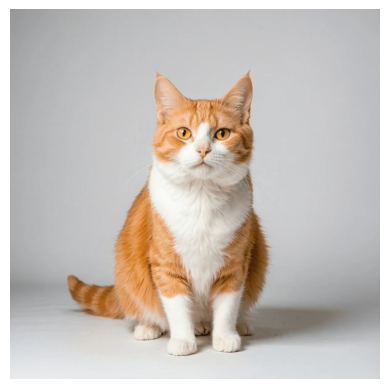

In [5]:
# 4. Forward pass through the model
with torch.no_grad():
    output = model(input_tensor)

# 5. Get top 3 predictions
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top3_prob, top3_idx = torch.topk(probabilities, 3)

# Load ImageNet class labels
with open("imagenet_classes.json", "r") as f:  # Ensure this file is downloaded
    class_labels = json.load(f)

# Print top 3 predicted classes
for i in range(3):
    print(f"Class: {class_labels[top3_idx[i].item()]}, Probability: {top3_prob[i].item()}")

plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()


In [6]:
# 6. Print architecture
print("\nModel Architecture:")
print(model)

# 7. Print input/output dimensions
print("\nInput Dimensions: [Batch Size, 3, 224, 224]")
print("Output Dimensions:", output.shape)


Model Architecture:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1):

In [7]:
# Define transforms for data preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

# Load Flowers102 dataset using Torchvision
train_dataset = datasets.Flowers102(root='./data', split='train', transform=data_transforms['train'], download=True)
val_dataset = datasets.Flowers102(root='./data', split='val', transform=data_transforms['val'], download=True)
test_dataset = datasets.Flowers102(root='./data', split='test', transform=data_transforms['test'], download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
model = models.mobilenet_v2(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

num_classes = 102
model.classifier[1] = nn.Linear(model.last_channel, num_classes)  # Replace the classifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
num_epochs = 20

In [10]:
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_acc_history.append(epoch_acc.item())
    train_loss_history.append(epoch_loss)

    # Validation phase
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
    val_acc_history.append(val_epoch_acc.item())
    val_loss_history.append(val_epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, "
          f"Train Acc: {epoch_acc:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Save the best model
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), "Best_MobileNet.pth")

Epoch 1/20, Train Loss: 4.3906, Val Loss: 3.3057, Train Acc: 0.1127, Val Acc: 0.3912
Epoch 2/20, Train Loss: 2.4942, Val Loss: 2.1497, Train Acc: 0.6402, Val Acc: 0.6882
Epoch 3/20, Train Loss: 1.4739, Val Loss: 1.5501, Train Acc: 0.8490, Val Acc: 0.7863
Epoch 4/20, Train Loss: 0.9275, Val Loss: 1.2486, Train Acc: 0.9324, Val Acc: 0.8078
Epoch 5/20, Train Loss: 0.6186, Val Loss: 1.0690, Train Acc: 0.9647, Val Acc: 0.8304
Epoch 6/20, Train Loss: 0.4503, Val Loss: 0.9502, Train Acc: 0.9814, Val Acc: 0.8412
Epoch 7/20, Train Loss: 0.3531, Val Loss: 0.8710, Train Acc: 0.9853, Val Acc: 0.8431
Epoch 8/20, Train Loss: 0.2706, Val Loss: 0.8115, Train Acc: 0.9912, Val Acc: 0.8539
Epoch 9/20, Train Loss: 0.2238, Val Loss: 0.7641, Train Acc: 1.0000, Val Acc: 0.8569
Epoch 10/20, Train Loss: 0.1960, Val Loss: 0.7382, Train Acc: 0.9951, Val Acc: 0.8578
Epoch 11/20, Train Loss: 0.1519, Val Loss: 0.7030, Train Acc: 0.9980, Val Acc: 0.8588
Epoch 12/20, Train Loss: 0.1322, Val Loss: 0.6856, Train Acc: 1

In [11]:
def plot_training_validation_metrics(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies):

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


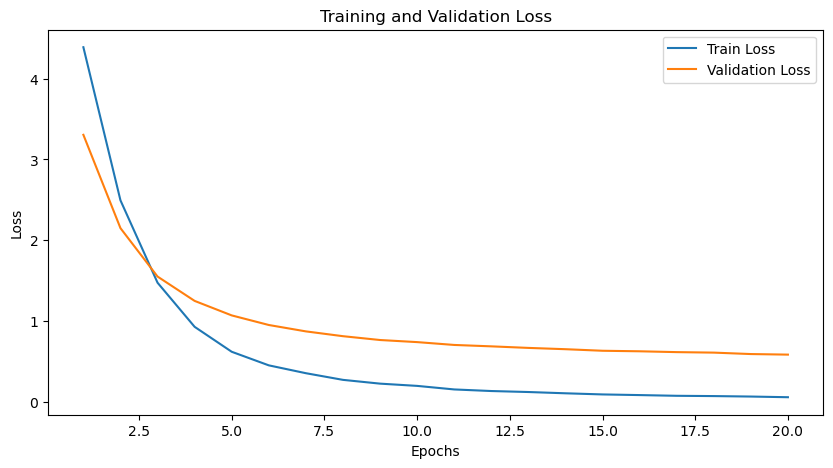

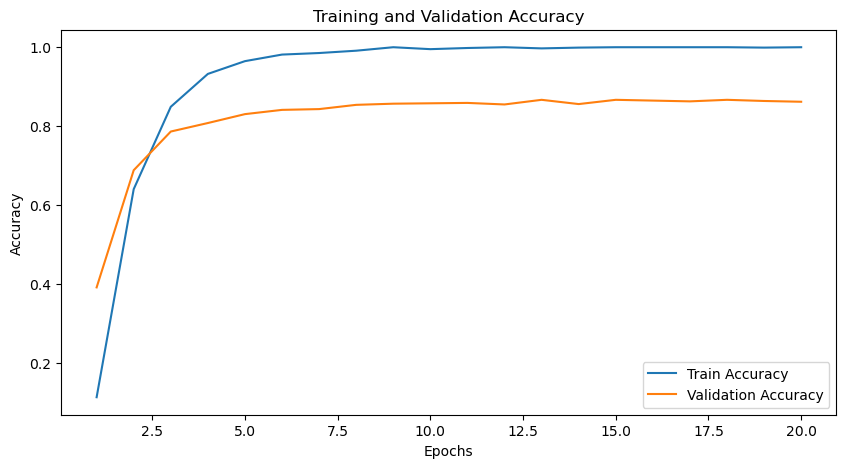

In [12]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_loss_history,
    val_losses=val_loss_history,
    train_accuracies=train_acc_history,
    val_accuracies=val_acc_history
)

In [13]:
# Step 6: Evaluate on Test Set
model.eval()
test_corrects = 0
test_running_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        loss = criterion(outputs, labels)  # Compute loss for test set
        test_running_loss += loss.item() * inputs.size(0)

test_accuracy = test_corrects.double() / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8489


In [14]:
test_cost = test_running_loss / len(test_loader.dataset)

print(f"Training Cost: {epoch_loss:.4f}")
print(f"Validation Cost: {val_epoch_loss:.4f}")
print(f"Test Cost: {test_cost:.4f}")

Training Cost: 0.0556
Validation Cost: 0.5832
Test Cost: 0.6658


In [15]:
print(f"Training Accuracy: {train_acc_history[-1]:.4f}")
print(f"Validation Accuracy: {val_acc_history[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Validation Accuracy: 0.8618
Test Accuracy: 0.8489


In [16]:
def count_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return total, trainable

In [17]:
mobilenetv2_params = count_parameters(model)
print(f"MobileNetV2: Total Parameters: {mobilenetv2_params[0]}, Trainable: {mobilenetv2_params[1]}")

MobileNetV2: Total Parameters: 2354534, Trainable: 130662


In [19]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_classes = 102
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace FC layer

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
num_epochs = 20

In [21]:
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_acc_history.append(epoch_acc.item())
    train_loss_history.append(epoch_loss)

    # Validation phase
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
    val_acc_history.append(val_epoch_acc.item())
    val_loss_history.append(val_epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, "
          f"Train Acc: {epoch_acc:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Save the best model
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), "Best_ResNet.pth")

Epoch 1/20, Train Loss: 4.1011, Val Loss: 3.1765, Train Acc: 0.1735, Val Acc: 0.3765
Epoch 2/20, Train Loss: 2.4081, Val Loss: 2.2552, Train Acc: 0.5843, Val Acc: 0.5471
Epoch 3/20, Train Loss: 1.4764, Val Loss: 1.5737, Train Acc: 0.8186, Val Acc: 0.7324
Epoch 4/20, Train Loss: 0.9464, Val Loss: 1.3145, Train Acc: 0.9098, Val Acc: 0.7755
Epoch 5/20, Train Loss: 0.6578, Val Loss: 1.1448, Train Acc: 0.9490, Val Acc: 0.7853
Epoch 6/20, Train Loss: 0.5071, Val Loss: 0.9999, Train Acc: 0.9667, Val Acc: 0.8324
Epoch 7/20, Train Loss: 0.3721, Val Loss: 0.9142, Train Acc: 0.9912, Val Acc: 0.8304
Epoch 8/20, Train Loss: 0.2902, Val Loss: 0.8553, Train Acc: 0.9833, Val Acc: 0.8392
Epoch 9/20, Train Loss: 0.2375, Val Loss: 0.8005, Train Acc: 0.9951, Val Acc: 0.8441
Epoch 10/20, Train Loss: 0.1888, Val Loss: 0.7514, Train Acc: 0.9971, Val Acc: 0.8529
Epoch 11/20, Train Loss: 0.1653, Val Loss: 0.7507, Train Acc: 0.9990, Val Acc: 0.8461
Epoch 12/20, Train Loss: 0.1343, Val Loss: 0.7139, Train Acc: 0

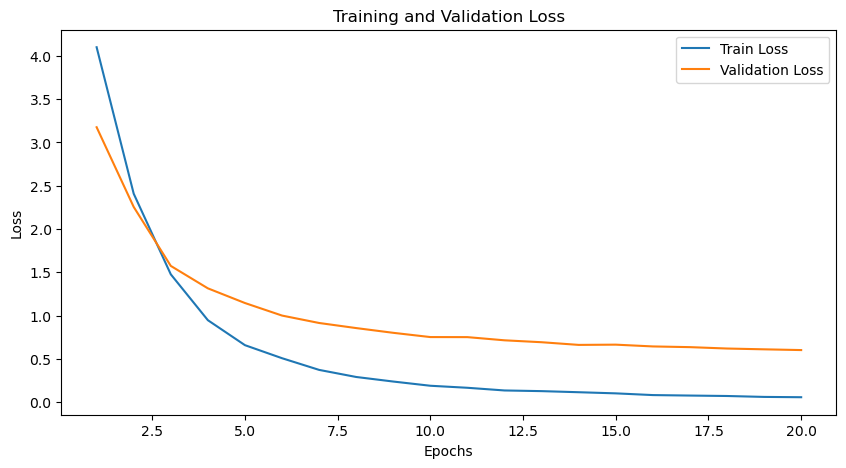

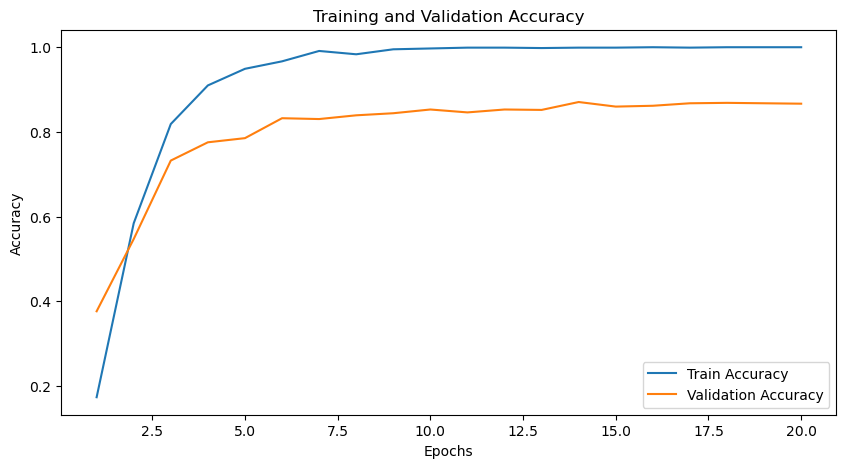

In [22]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_loss_history,
    val_losses=val_loss_history,
    train_accuracies=train_acc_history,
    val_accuracies=val_acc_history
)

In [23]:
model.eval()
test_corrects = 0
test_running_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        loss = criterion(outputs, labels)  # Compute loss for test set
        test_running_loss += loss.item() * inputs.size(0)

test_accuracy = test_corrects.double() / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8396


In [24]:
test_cost = test_running_loss / len(test_loader.dataset)

print(f"Training Cost: {epoch_loss:.4f}")
print(f"Validation Cost: {val_epoch_loss:.4f}")
print(f"Test Cost: {test_cost:.4f}")

Training Cost: 0.0563
Validation Cost: 0.6012
Test Cost: 0.7011


In [25]:
print(f"Training Accuracy: {train_acc_history[-1]:.4f}")
print(f"Validation Accuracy: {val_acc_history[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Validation Accuracy: 0.8667
Test Accuracy: 0.8396


In [29]:
resnet50_params = count_parameters(model)
print(f"ResNet50: Total Parameters: {resnet50_params[0]}, Trainable: {resnet50_params[1]}")

ResNet50: Total Parameters: 23717030, Trainable: 208998


In [31]:
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extraction layer

num_classes = 102

model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=0.001)
num_epochs = 20

In [38]:
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_acc_history.append(epoch_acc.item())
    train_loss_history.append(epoch_loss)

    # Validation phase
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
    val_acc_history.append(val_epoch_acc.item())
    val_loss_history.append(val_epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, "
          f"Train Acc: {epoch_acc:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Save the best model
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), "Best_VGG.pth")

Epoch 1/20, Train Loss: 0.0698, Val Loss: 0.9210, Train Acc: 0.9961, Val Acc: 0.7500
Epoch 2/20, Train Loss: 0.0666, Val Loss: 0.9138, Train Acc: 0.9971, Val Acc: 0.7588
Epoch 3/20, Train Loss: 0.0638, Val Loss: 0.9186, Train Acc: 0.9941, Val Acc: 0.7549
Epoch 4/20, Train Loss: 0.0509, Val Loss: 0.9136, Train Acc: 0.9980, Val Acc: 0.7618
Epoch 5/20, Train Loss: 0.0529, Val Loss: 0.9101, Train Acc: 0.9971, Val Acc: 0.7637
Epoch 6/20, Train Loss: 0.0511, Val Loss: 0.9110, Train Acc: 0.9961, Val Acc: 0.7647
Epoch 7/20, Train Loss: 0.0495, Val Loss: 0.9150, Train Acc: 0.9971, Val Acc: 0.7549
Epoch 8/20, Train Loss: 0.0525, Val Loss: 0.9141, Train Acc: 0.9912, Val Acc: 0.7588
Epoch 9/20, Train Loss: 0.0417, Val Loss: 0.9268, Train Acc: 0.9941, Val Acc: 0.7539
Epoch 10/20, Train Loss: 0.0452, Val Loss: 0.8907, Train Acc: 0.9971, Val Acc: 0.7559
Epoch 11/20, Train Loss: 0.0439, Val Loss: 0.9332, Train Acc: 0.9971, Val Acc: 0.7441
Epoch 12/20, Train Loss: 0.0450, Val Loss: 0.9092, Train Acc: 0

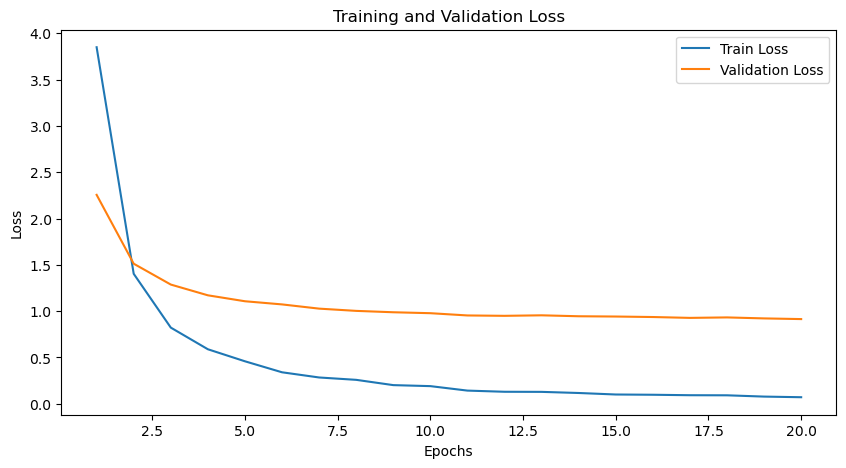

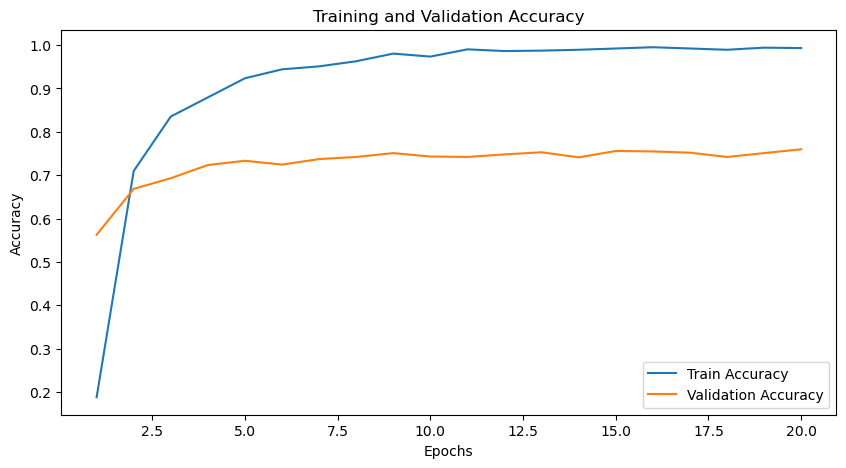

In [33]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_loss_history,
    val_losses=val_loss_history,
    train_accuracies=train_acc_history,
    val_accuracies=val_acc_history
)

In [34]:
model.eval()
test_corrects = 0
test_running_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        loss = criterion(outputs, labels)  # Compute loss for test set
        test_running_loss += loss.item() * inputs.size(0)

test_accuracy = test_corrects.double() / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7390


In [35]:
test_cost = test_running_loss / len(test_loader.dataset)

print(f"Training Cost: {epoch_loss:.4f}")
print(f"Validation Cost: {val_epoch_loss:.4f}")
print(f"Test Cost: {test_cost:.4f}")

Training Cost: 0.0698
Validation Cost: 0.9138
Test Cost: 1.0088


In [36]:
print(f"Training Accuracy: {train_acc_history[-1]:.4f}")
print(f"Validation Accuracy: {val_acc_history[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9931
Validation Accuracy: 0.7598
Test Accuracy: 0.7390


In [37]:
vgg16_params = count_parameters(model)
print(f"VGG16: Total Parameters: {vgg16_params[0]}, Trainable: {vgg16_params[1]}")

VGG16: Total Parameters: 134678438, Trainable: 119963750


### Comparison of Pretrained Models: MobileNetV2, ResNet50, and VGG16

Here is a brief comparison of the three pretrained models in terms of parameter count, trainable parameters, and accuracy (training, validation, and test):

| **Model**       | **Total Parameters** | **Trainable Parameters** | **Training Accuracy** | **Validation Accuracy** | **Test Accuracy** |
|------------------|----------------------|---------------------------|------------------------|--------------------------|--------------------|
| **MobileNetV2**  | 2,354,534            | 130,662                  | 1.0000                | 0.8618                  | 0.8489            |
| **ResNet50**     | 23,717,030           | 208,998                  | 1.0000                | 0.8667                  | 0.8396            |
| **VGG16**        | 134,678,438          | 11,996,375               | 0.9931                | 0.7598                  | 0.7390            |

### Observations

1. **Parameter Efficiency**:
   - MobileNetV2 has the **fewest parameters** (2.35M), making it the most parameter-efficient model.
   - VGG16 has the **highest number of parameters** (134.68M), resulting in a larger memory footprint and slower computation.

2. **Trainable Parameters**:
   - MobileNetV2 also has the fewest trainable parameters (130K), which reduces the computational cost significantly.
   - VGG16 has over 11M trainable parameters, making it computationally intensive.

3. **Accuracy**:
   - All models achieve near-perfect **training accuracy**, but overfitting is more evident in VGG16, as the **validation** and **test accuracy** are notably lower compared to MobileNetV2 and ResNet50.
   - MobileNetV2 and ResNet50 achieve similar test accuracies (~84%), with MobileNetV2 being slightly better despite having fewer parameters.

4. **Trade-offs**:
   - **MobileNetV2** is best suited for environments with limited computational resources, achieving high accuracy with minimal parameters.
   - **ResNet50** balances model complexity and accuracy, making it suitable for a wide range of tasks.
   - **VGG16** provides lower accuracy and requires significantly more computational resources, which might make it less favorable for practical applications.

# Without Pretrainnig

In [42]:
model = models.mobilenet_v2(pretrained=False)

num_classes = 102
model.classifier[1] = nn.Linear(model.last_channel, num_classes)  # Replace the classifier

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
num_epochs = 50

In [43]:
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_acc_history.append(epoch_acc.item())
    train_loss_history.append(epoch_loss)

    # Validation phase
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
    val_acc_history.append(val_epoch_acc.item())
    val_loss_history.append(val_epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, "
          f"Train Acc: {epoch_acc:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Save the best model
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), "Best_MobileNet_from_scratch.pth")

Epoch 1/50, Train Loss: 4.9749, Val Loss: 4.7181, Train Acc: 0.0098, Val Acc: 0.0098
Epoch 2/50, Train Loss: 4.7873, Val Loss: 4.7613, Train Acc: 0.0078, Val Acc: 0.0108
Epoch 3/50, Train Loss: 4.7194, Val Loss: 4.6285, Train Acc: 0.0118, Val Acc: 0.0157
Epoch 4/50, Train Loss: 4.6996, Val Loss: 4.6401, Train Acc: 0.0167, Val Acc: 0.0157
Epoch 5/50, Train Loss: 4.6907, Val Loss: 4.6290, Train Acc: 0.0127, Val Acc: 0.0176
Epoch 6/50, Train Loss: 4.6480, Val Loss: 4.6165, Train Acc: 0.0167, Val Acc: 0.0235
Epoch 7/50, Train Loss: 4.6358, Val Loss: 4.6070, Train Acc: 0.0147, Val Acc: 0.0196
Epoch 8/50, Train Loss: 4.6168, Val Loss: 4.5716, Train Acc: 0.0108, Val Acc: 0.0245
Epoch 9/50, Train Loss: 4.5897, Val Loss: 4.6046, Train Acc: 0.0176, Val Acc: 0.0167
Epoch 10/50, Train Loss: 4.5887, Val Loss: 4.5619, Train Acc: 0.0255, Val Acc: 0.0216
Epoch 11/50, Train Loss: 4.5767, Val Loss: 4.5485, Train Acc: 0.0206, Val Acc: 0.0294
Epoch 12/50, Train Loss: 4.5382, Val Loss: 4.5725, Train Acc: 0

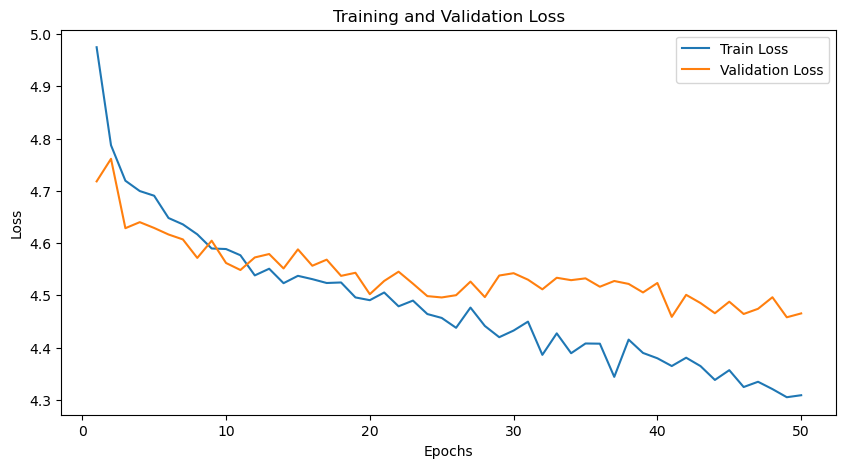

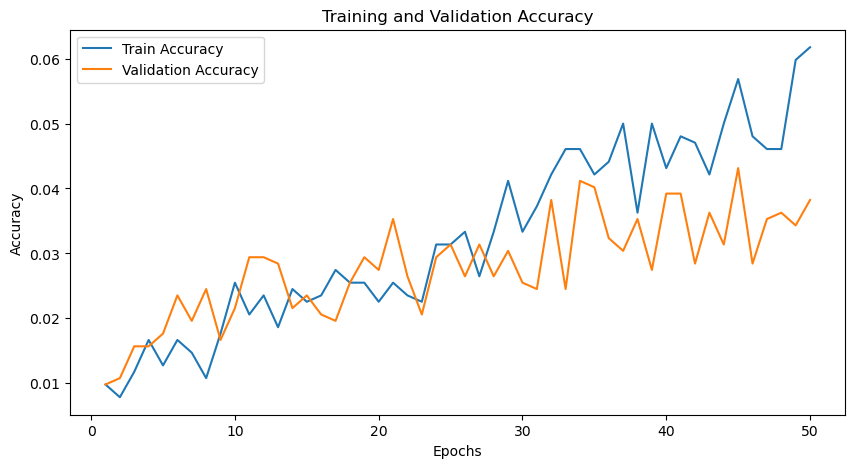

In [44]:
plot_training_validation_metrics(
    num_epochs=num_epochs,
    train_losses=train_loss_history,
    val_losses=val_loss_history,
    train_accuracies=train_acc_history,
    val_accuracies=val_acc_history
)

In [45]:
model.eval()
test_corrects = 0
test_running_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        loss = criterion(outputs, labels)  # Compute loss for test set
        test_running_loss += loss.item() * inputs.size(0)

test_accuracy = test_corrects.double() / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.0327


In [46]:
test_cost = test_running_loss / len(test_loader.dataset)

print(f"Training Cost: {epoch_loss:.4f}")
print(f"Validation Cost: {val_epoch_loss:.4f}")
print(f"Test Cost: {test_cost:.4f}")

Training Cost: 4.3088
Validation Cost: 4.4654
Test Cost: 4.5724


In [47]:
print(f"Training Accuracy: {train_acc_history[-1]:.4f}")
print(f"Validation Accuracy: {val_acc_history[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.0618
Validation Accuracy: 0.0382
Test Accuracy: 0.0327


In [48]:
mobilenet_from_scratch_params = count_parameters(model)
print(f"MObileNet: Total Parameters: {mobilenet_from_scratch_params[0]}, Trainable: {mobilenet_from_scratch_params[1]}")

MObileNet: Total Parameters: 2354534, Trainable: 2354534


### Comparison of Models: MobileNetV2 (From Scratch) vs Transfer Learning

| **Model**             | **Training Cost** | **Validation Cost** | **Test Cost** | **Training Accuracy** | **Validation Accuracy** | **Test Accuracy** |
|------------------------|-------------------|---------------------|---------------|------------------------|--------------------------|--------------------|
| **MobileNetV2 (Scratch)** | 4.3088           | 4.4654              | 4.5724        | 0.0618                | 0.0382                  | 0.0327            |
| **MobileNetV2 (Transfer)** | 0.0556           | 0.5832              | 0.6658        | 1.0000                | 0.8618                  | 0.8489            |

---

### Observations

1. **Cost**:
   - Training MobileNetV2 from scratch incurs a much higher training and validation cost.
   - Transfer learning dramatically reduces the cost and improves efficiency.

2. **Accuracy**:
   - The model trained from scratch has significantly lower accuracy across training, validation, and test datasets.
   - Transfer learning provides near-perfect training accuracy and high validation/test accuracy, showing better generalization.


### Benefits of Transfer Learning

Transfer learning is a machine learning technique where a pre-trained model is used as the starting point for a new task. This approach offers several advantages:

1. **Reduced Training Time**:
   - Leveraging pre-trained weights significantly reduces the training time, as the model has already learned general features from a large dataset.

2. **Better Generalization**:
   - Transfer learning enables the model to generalize better on small datasets, as it builds on knowledge from large-scale datasets.

3. **Works Well with Limited Data**:
   - Useful for applications with limited labeled data, as the pre-trained model provides robust feature extraction capabilities.

4. **Efficient Use of Resources**:
   - Computationally efficient, since the earlier layers do not require retraining in most cases, saving computational cost.

5. **Improves Performance**:
   - Often achieves higher accuracy and lower loss compared to training a model from scratch, especially on smaller datasets.

6. **Versatility**:
   - Applicable across various domains such as image classification, natural language processing, and object detection.
